In [1]:
import sys
sys.path.insert(0, '/global/u2/y/yaswante/gcr-catalogs') 

In [2]:
import os, re, json, time
import numpy as np
import pandas as pd
import multiprocessing as mp
import gc
import random
import pickle

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, make_lupton_rgb
from scipy.ndimage import zoom 

import lsst.daf.persistence as dafPersist
import lsst.geom as geom
from lsst.afw.fits import makeLimitedFitsHeader

import GCRCatalogs
from GCRCatalogs import GCRQuery
import healpy as hp

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cachetools import cached
from cachetools.keys import hashkey
from multiprocessing import Manager
from functools import lru_cache, partial
from pathlib import Path
from tqdm import tqdm

In [3]:
GCRCatalogs.__version__

'1.10.1'

In [4]:
# manager for sharing cache b/w processes
manager = Manager()
shared_cache = manager.dict()
pd.options.mode.chained_assignment = None

In [5]:
# --- Setup LSST Butler and Skymap ---
repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
butler = dafPersist.Butler(repo)
skymap = butler.get("deepCoadd_skyMap")

In [ ]:
tract_ids = [tract.getId() for tract in skymap]
len(tract_ids) # 18938 tracts in total

In [13]:
def find_tract_patch(ra, dec, skymap):
    """
    Finds LSST tract and patch for a given RA & Dec
    Args:
        ra (np.ndarray) in degrees
        dec (np.ndarray) in degrees
        skymap: LSST skymap object obtained from Butler

    Returns:
        tract_ids & patch_idxs (np.ndarray)
    """
    try:
        spherePoints = [geom.SpherePoint(r * geom.degrees, d * geom.degrees) for r, d in zip(ra, dec)]
        tracts = [skymap.findTract(spherePoint) for spherePoint in spherePoints]
        patches = [patchInfo.getIndex() for spherePoint, tractInfo in zip(spherePoints, tracts) 
                      for patchInfo in [tractInfo.findPatch(spherePoint)]]
        patch_idxs = [",".join(map(str, idx)) for idx in patches]
        tract_ids = [tractInfo.getId() for tractInfo in tracts]
        # tractInfo = skymap.findTract(spherePoint)
        # patchInfo = tractInfo.findPatch(spherePoint)
        # tract_ids = [tract_patch[0].getId() for tract_patch in tract_patches]
        # patch_idxs = [f"{idx[0]},{idx[1]}"  
        #               for tract_patch in tract_patches
        #               for idx in [tract_patch[1][0].getIndex()]]
        # uses map(str, idx) to convert each ele of idx to a string
        # ",".join to concat them w/ comma 
        # patch_idxs = [",".join(map(str, idx)) 
        #       for tract_patch in tract_patches
        #       for idx in [tract_patch[1][0].getIndex()]]

        return np.array(tract_ids), np.array(patch_idxs)
    except Exception as e: 
        print(f"Warning: Could not find tract/patch for some RA, Dec: {e}. Not within this skymap")
        return None, None

In [7]:
plt.rcParams['figure.figsize'] = (10, 10)
zscale = ZScaleInterval()
root_dir = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
roman_dir = f'{root_dir}truth-roman/'
lsst_dir = f'{root_dir}truth-lsst/'

# Creating Roman Master Truth Catalog

## For a Single Tile

In [17]:
tile = '51.23_-38.5'

In [20]:
cutout_paths = [
    f'{roman_dir}{tile}/truth_c{cutout_id}_{tile}.json'
    for cutout_id in range(225) 
]
dfs = [pd.read_json(path, orient='records') for path in tqdm(cutout_paths)]
master_df = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(master_df)} total objects from 225 cutouts in tile {tile}") # ~5.34 MB w/ all columns around 0.254112 MB

100%|██████████| 225/225 [00:02<00:00, 90.33it/s]


Loaded 31764 total objects from 225 cutouts in tile 51.23_-38.5


## For All 700 Tiles

In [7]:
TILE_LIST_FILE = f'{root_dir}700_tiles.txt'
with open(TILE_LIST_FILE, 'r') as f:
    tiles = [line.strip() for line in f if line.strip()]

In [8]:
# let's also pass in the tile so that we can add a tile column later 
# for easy access to data per tile
tasks = [
    (f'{roman_dir}{tile}/truth_c{cutout_id}_{tile}.json', tile)
    for tile in tiles for cutout_id in range(225)
]
def load_json(path_and_tile):
    path, tile = path_and_tile
    return pd.read_json(path, orient='records').assign(tile=tile) # in-place col addition

In [10]:
if __name__ == '__main__':
    start_time = time.time()
    with mp.Pool(processes=256) as pool: # Max CPUs on cpu-node for NERSC is 256
        # we pass each tuple from tasks to load_json function through pool.map
        dfs = pool.map(load_json, tasks)
    elapsed_time = time.time() - start_time
    print(f"Loading and tagging all dataframes completed in {elapsed_time:.2f}s")
    master_df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(master_df)} total objects from {len(tasks)} cutouts from {len(tiles)} tiles.") # 9.65 GB
    elapsed_time = time.time() - start_time
    print(f"Master df creation completed in {elapsed_time:.2f}s")

Loading and tagging all dataframes completed in 106.15s
Loaded 22826184 total objects from 157500 cutouts from 700 tiles.
Master df creation completed in 246.29s


In [11]:
master_df.to_parquet(f'{root_dir}roman_master_truth_df_700_w_tile.parquet') # 2.55 GB

JSON stores strings compactly, but when we load the file through pandas, it loads them as full str objects and each string carries overhead: pointers, hash values, and internal buffers. So, we choose to save our files as parquet files.

## Corners from Entire Roman Truth Catalog

In [8]:
master_df = pd.read_parquet(f'{root_dir}roman_master_truth_df_700.parquet')

In [12]:
len(master_df['ind'].unique())

22815953

In [13]:
master_df['mag_Y106'].describe().apply(lambda x: format(x, 'f'))

count    22826184.000000
mean           26.738871
std             2.121430
min             0.000000
25%            26.046410
50%            27.056233
75%            27.883255
max            31.004187
Name: mag_Y106, dtype: object

In [41]:
master_df

,cutout_id,cutout_x,cutout_y,dec,dered_F184,dered_H158,dered_J129,dered_Y106,dither,gal_star,...,mag_F184,mag_H158,mag_J129,mag_Y106,ra,sca,stamp,start_row,x,y
0,0,330.668576,368.456715,-40.001025,-0.013256,-0.017133,-0.023677,-0.032366,133739,1,...,16.618387,16.513267,16.568469,16.727875,51.018643,18,0,0,830.754489,868.626262
1,0,404.770947,428.915144,-40.000060,-0.033903,-0.043938,-0.060393,-0.082276,133739,0,...,27.239958,27.224346,27.202740,27.322395,51.017096,18,0,0,904.856869,929.084680
2,0,216.871957,300.619249,-40.002107,0.000000,0.000000,0.000000,0.000000,133739,0,...,26.520891,26.499967,26.466262,26.538156,51.021017,18,0,0,716.957861,800.788812
3,0,93.264671,38.586510,-40.006290,-0.030626,-0.039738,-0.054895,-0.075600,133739,0,...,24.286113,24.322140,24.408684,24.578962,51.023599,18,128,0,593.350537,538.756091
4,0,388.843289,148.021269,-40.004546,-0.070321,-0.091234,-0.125311,-0.171330,133739,0,...,25.832322,25.803934,25.800685,25.932492,51.017433,18,128,0,888.929171,648.190807
5,0,103.633194,276.497254,-40.002490,-0.015978,-0.020726,-0.028471,-0.038936,133739,0,...,25.836479,25.803450,25.779522,25.879538,51.023378,18,512,0,603.719095,776.666833
6,0,494.628214,22.209422,-40.006557,-0.016764,-0.021704,-0.029734,-0.040574,133739,0,...,25.976336,25.933817,25.914302,26.016200,51.015230,18,256,0,994.714078,522.378945
7,0,162.436672,108.557275,-40.005174,-0.026001,-0.033706,-0.046222,-0.063279,133739,0,...,28.011950,27.976009,27.973146,28.102559,51.022155,18,0,0,662.522548,608.726846
8,0,88.514402,322.743967,-40.001751,-0.018297,-0.023746,-0.032534,-0.044597,133739,0,...,28.429152,28.353549,28.307526,28.356725,51.023692,18,0,0,588.600309,822.913548
9,0,260.236633,102.173792,-40.005277,-0.017816,-0.023093,-0.031644,-0.043424,133739,0,...,26.677091,26.594018,26.566932,26.621929,51.020116,18,0,0,760.322509,602.343349


In [9]:
ra_min, ra_max, dec_min, dec_max = master_df['ra'].min(), master_df['ra'].max(), master_df['dec'].min(), master_df['dec'].max()
roman_corners = np.array(
    [(ra_min, dec_min), # bottom left
     (ra_max, dec_min), # bottom right
     (ra_max, dec_max), # top right
     (ra_min, dec_max) # top left
    ]
)
ras, decs = roman_corners[:, 0], roman_corners[:, 1]

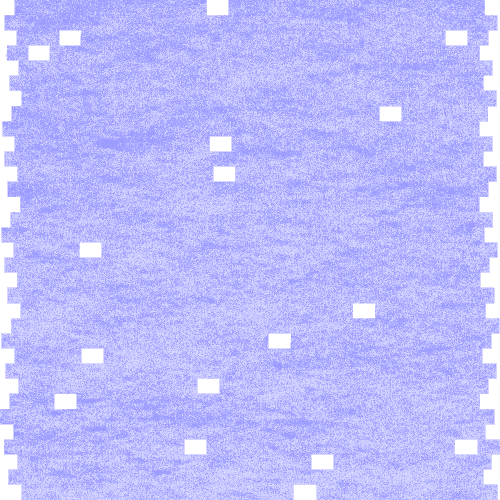

In [18]:
# plt.scatter(master_df['ra'].values, master_df['dec'].values, s=0.0001, alpha=0.5, label='Roman Truth Objects')
# for corner in corners:
#     plt.scatter(corner[0], corner[1], c=['red'])
# plt.legend()
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd

canvas = ds.Canvas(plot_width=500, plot_height=500)
agg = canvas.points(master_df, 'ra', 'dec')
img = tf.shade(agg, cmap='blue', alpha=100)
img.to_pil()

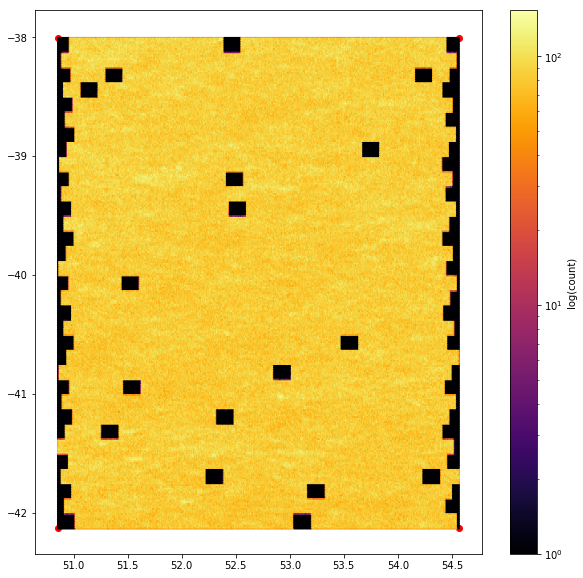

In [24]:
for corner in roman_corners:
    plt.scatter(corner[0], corner[1], c=['red'])
plt.hexbin(master_df['ra'], master_df['dec'], gridsize=500, cmap='inferno', bins='log')
plt.colorbar(label='log(count)')

# Which Tracts Overlap with these Roman Objects?

In [11]:
roman_corners

array([[ 50.85345112, -42.13163965],
       [ 54.56547722, -42.13163965],
       [ 54.56547722, -38.00728567],
       [ 50.85345112, -38.00728567]])

Based on https://confluence.slac.stanford.edu/download/attachments/272996316/Run2.2i_y02_missing_visits.png?version=1&modificationDate=1584661514000&api=v2, we can eyeball which tracts seem to overlap with our Roman data using the corner coords.

![Skymap from DESC Confluence Page about DESC DRP DC2 Run2.2i Processing](https://confluence.slac.stanford.edu/download/attachments/272996316/Run2.2i_y02_missing_visits.png?version=1&modificationDate=1584661514000&api=v2)

```
3074, 3075, 3076, 3077, 
3256, 3257, 3258, 3259
3441, 3442, 3443, 3444, 
3631, 3632, 3633, 3634
3825, 3826, 3827
```

In [45]:
overlapping_tract_ids = [
    3074, 3075, 3076, 3077, 
    3256, 3257, 3258, 3259,
    3441, 3442, 3443, 3444, 
    3631, 3632, 3633, 3634,
    3825, 3826, 3827  
]

In [46]:
corners = [skymap[tract].getVertexList() for tract in overlapping_tract_ids]
corners

[[SpherePoint(50.79000640481168*geom.degrees, -43.16944559566159*geom.degrees),
  SpherePoint(48.65743126152283*geom.degrees, -43.169444888480385*geom.degrees),
  SpherePoint(48.6835340227126*geom.degrees, -41.61424772832186*geom.degrees),
  SpherePoint(50.763905506778514*geom.degrees, -41.61424839798025*geom.degrees)],
 [SpherePoint(52.77895668105475*geom.degrees, -43.1694455956616*geom.degrees),
  SpherePoint(50.64638153776591*geom.degrees, -43.16944488848039*geom.degrees),
  SpherePoint(50.67248429895567*geom.degrees, -41.614247728321864*geom.degrees),
  SpherePoint(52.7528557830216*geom.degrees, -41.614248397980255*geom.degrees)],
 [SpherePoint(54.76790695729788*geom.degrees, -43.1694455956616*geom.degrees),
  SpherePoint(52.63533181400904*geom.degrees, -43.16944488848039*geom.degrees),
  SpherePoint(52.661434575198804*geom.degrees, -41.614247728321864*geom.degrees),
  SpherePoint(54.741806059264725*geom.degrees, -41.614248397980255*geom.degrees)],
 [SpherePoint(56.75685723354097*g

In [49]:
from matplotlib.patches import Polygon
def plot_tracts_from_corners(corners_list, tract_ids):
    """
    Plots tract polygons on an RA/Dec grid, colored by tract
    Also Roman data polygon
    
    Args:
        corners_list (list): List of lists of coordinates, where each inner list contains 
                             corner coord objs (with .getRa().asDegrees(), .getDec().asDegrees()).
        tract_ids (list): List of tract IDs for the polygons
    """
    if not corners_list or not tract_ids or len(corners_list) != len(tract_ids):
        print("Empty or mismatched corners/tract IDs list. Nothing to plot.")
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    color_map = plt.cm.get_cmap('tab20', len(tract_ids))
    tract_colors = {tract: color_map(i) for i, tract in enumerate(tract_ids)}
    legend_handles = {}
    
    # Roman patch
    for corner in roman_corners:        
        plt.scatter(corner[0], corner[1], c=['red'], marker='x', s=200)
    roman_patch = Polygon(roman_corners, closed=True,
                 facecolor='darkblue', alpha=0.6,
                 edgecolor='black', linewidth=3,
                hatch='/x', linestyle='--',
                 label=f'Roman')
    ax.add_patch(roman_patch)
        
    for tract_corners, tract_id in zip(corners_list, tract_ids):
        ra_coords = [corner.getRa().asDegrees() for corner in tract_corners]
        dec_coords = [corner.getDec().asDegrees() for corner in tract_corners]
        
        polygon_coords = list(zip(ra_coords, dec_coords))
        
        poly_patch = Polygon(polygon_coords, closed=True,
                             facecolor=tract_colors[tract_id], alpha=0.5,
                             edgecolor='black', linewidth=0.7,
                             label=f'{tract_id}')
        ax.add_patch(poly_patch)
        
        # first handle for legend
        if tract_id not in legend_handles:
            legend_handles[tract_id] = poly_patch
        center_ra = np.mean(ra_coords)
        center_dec = np.mean(dec_coords)
        ax.text(center_ra, center_dec, f'{tract_id}', ha='center', va='center',
                fontsize=10, clip_on=True)

    ax.set_xlabel('RA (degrees)')
    ax.set_ylabel('DEC (degrees)')
    ax.set_title('Potential LSST Tracts that Overlap with Roman Data')

    # axis lims
    all_ra = np.concatenate([np.array([corner.getRa().asDegrees() for corner in corners]) for corners in corners_list])
    all_dec = np.concatenate([np.array([corner.getDec().asDegrees() for corner in corners]) for corners in corners_list])    
    ra_min, ra_max = np.min(all_ra), np.max(all_ra)
    dec_min, dec_max = np.min(all_dec), np.max(all_dec)
    ra_pad = (ra_max - ra_min) * 0.05
    dec_pad = (dec_max - dec_min) * 0.05
    ax.set_xlim(ra_min - ra_pad, ra_max + ra_pad)
    ax.set_ylim(dec_min - dec_pad, dec_max + dec_pad)

    sorted_handles = [legend_handles[tract] for tract in sorted(legend_handles.keys())]
    ax.legend(handles=sorted_handles, title="Tracts", loc='upper left', bbox_to_anchor=(1.02, 1.0))

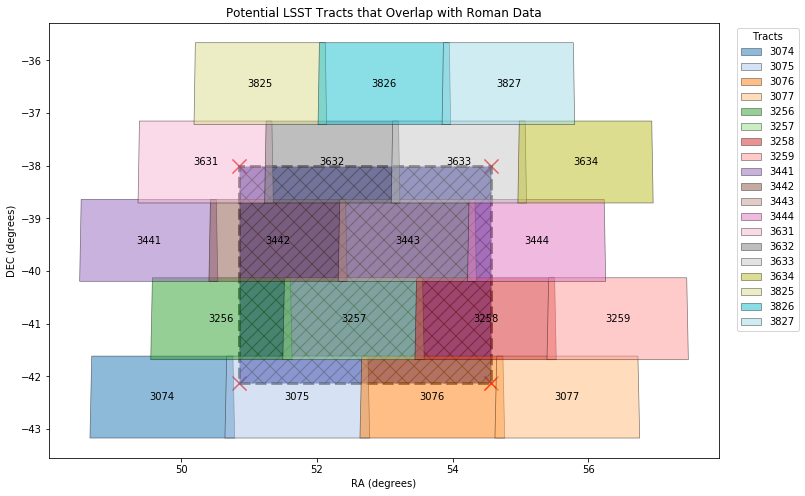

In [50]:
plot_tracts_from_corners(corners, overlapping_tract_ids)

So, from this plot, we can clearly see exactly which tracts overlap with our Roman data. 
```
3633, 3632, 3631,
3444, 3443, 3442,
3258, 3257, 3256,
3077, 3076, 3075, 3074
```

Now, let's take a look at which of their specific patches overlap. 

# Which Patches Overlap with these Roman Objects?

In [12]:
exact_overlapping_tracts = [
    3633, 3632, 3631,
    3444, 3443, 3442,
    3258, 3257, 3256,
    3077, 3076, 3075, 3074
]

We know that each tract has 7x7 patches from `[skymap[tract].getNumPatches() for tract in exact_overlapping_tracts]`. Now, let's find the corners of these patches so we can plot them accordingly.

In [103]:
overlap_corners = [skymap[tract].getVertexList() for tract in exact_overlapping_tracts]
tractInfos = [skymap[tract] for tract in exact_overlapping_tracts]

In [121]:
patch_idxs = [(i, j) for j in range(7) for i in range(7)]
for patch_idx in patch_idxs:
    # print(patch_idx)
    patchInfo = tractInfos[0].getPatchInfo(patch_idx)

In [137]:
def plot_tracts_and_patches(corners_list, tract_ids, tract_infos):
    """
    Plots tract polygons and their patches on an RA/Dec grid, colored by tract.
    Also Roman data polygon

    Args:
        corners_list (list): List of lists of corner coord objs per tract
        tract_ids (list): List of tract IDs
        tract_infos (list): List of TractInfo objects, one per tract
    """
    if not corners_list or not tract_ids or len(corners_list) != len(tract_ids):
        print("Empty or mismatched corners/tract IDs list. Nothing to plot.")
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    color_map = plt.cm.get_cmap('tab20', len(tract_ids))
    tract_colors = {tract: color_map(i) for i, tract in enumerate(tract_ids)}
    legend_handles = {}

    for corner in roman_corners:
        plt.scatter(corner[0], corner[1], c='red', marker='x', s=200)
    roman_patch = Polygon(roman_corners, closed=True,
                          facecolor='darkblue', alpha=0.6,
                          edgecolor='black', linewidth=3,
                          hatch='/x', linestyle='--',
                          label='Roman')
    ax.add_patch(roman_patch)

    patch_idxs = [(i, j) for j in range(7) for i in range(7)]
    for tract_corners, tract_id, tractInfo in zip(corners_list, tract_ids, tract_infos):
        ra_coords = [corner.getRa().asDegrees() for corner in tract_corners]
        dec_coords = [corner.getDec().asDegrees() for corner in tract_corners]
        polygon_coords = list(zip(ra_coords, dec_coords))
        
        tract_poly = Polygon(polygon_coords, closed=True,
                             facecolor=tract_colors[tract_id], alpha=0.5,
                             edgecolor='black', linewidth=0.7,
                             label=f'{tract_id}')
        ax.add_patch(tract_poly)

        if tract_id not in legend_handles:
            legend_handles[tract_id] = tract_poly
        
        # plotting patches
        tractWCS = tractInfo.getWcs()
        for patch_idx in patch_idxs:
            patchInfo = tractInfo.getPatchInfo(patch_idx)
            outer_bbox = patchInfo.getOuterBBox()
            bbox = geom.Box2D(outer_bbox)
            center_pix = bbox.getCenter()
            patch_corners_pix = bbox.getCorners()
            patch_radec = [(tractWCS.pixelToSky(corner).getRa().asDegrees(),
                            tractWCS.pixelToSky(corner).getDec().asDegrees()) for corner in patch_corners_pix]
            patch_poly = Polygon(patch_radec, closed=True,
                                 facecolor=tract_colors[tract_id],
                                 edgecolor='gray', linewidth=0.5,
                                 alpha=0.3, linestyle='--')
            ax.add_patch(patch_poly)
            center_sky = tractWCS.pixelToSky(center_pix)
            center_ra = center_sky.getRa().asDegrees()
            center_dec = center_sky.getDec().asDegrees()
            ax.text(center_ra, center_dec, f'{patch_idx}', ha='center', va='center',
                    fontsize=5, clip_on=True)
            
    ax.set_xlabel('RA (degrees)')
    ax.set_ylabel('DEC (degrees)')
    ax.set_title('LSST Tracts and Patches Overlapping Roman Data')

    all_ra = np.concatenate([np.array([corner.getRa().asDegrees() for corner in corners]) for corners in corners_list])
    all_dec = np.concatenate([np.array([corner.getDec().asDegrees() for corner in corners]) for corners in corners_list])    
    ra_min, ra_max = np.min(all_ra), np.max(all_ra)
    dec_min, dec_max = np.min(all_dec), np.max(all_dec)
    ra_pad = (ra_max - ra_min) * 0.05
    dec_pad = (dec_max - dec_min) * 0.05
    ax.set_xlim(ra_min - ra_pad, ra_max + ra_pad)
    ax.set_ylim(dec_min - dec_pad, dec_max + dec_pad)
    
    sorted_handles = [legend_handles[tract] for tract in sorted(legend_handles.keys())]
    ax.legend(handles=sorted_handles, title="Tracts & Roman", loc='upper left', bbox_to_anchor=(1.02, 1.0))

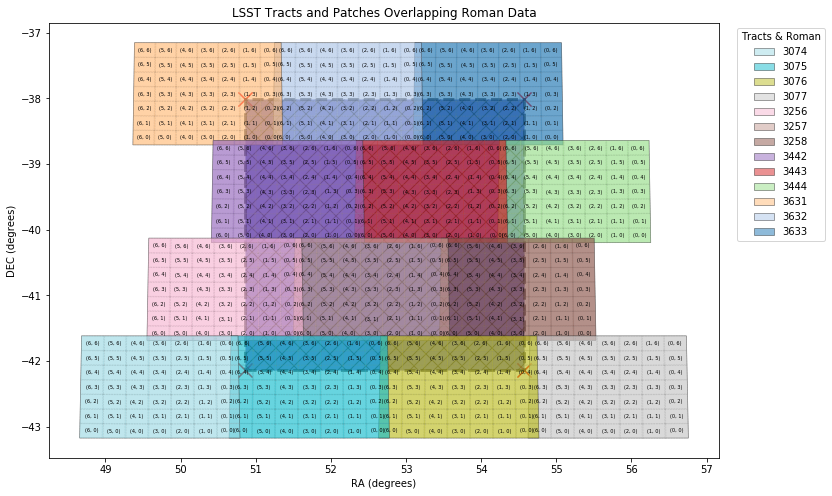

In [138]:
plot_tracts_and_patches(overlap_corners, exact_overlapping_tracts, tractInfos)

Great! Now, we can clearly see which patches of each tract actually overlap with our Roman data. We can use this to double check the patches we get from each tract after cross-matching the Roman data with the LSST catalogs.

# Creating LSST Master Truth Catalog

## Querying Truth Catalog ONCE

In [20]:
sorted(GCRCatalogs.load_catalog('dc2_run2.2i_truth_merged_summary').list_all_quantities())

['av',
 'cosmodc2_hp',
 'cosmodc2_id',
 'dec',
 'flux_g',
 'flux_i',
 'flux_r',
 'flux_u',
 'flux_y',
 'flux_z',
 'host_galaxy',
 'id',
 'id_string',
 'mag_g',
 'mag_i',
 'mag_r',
 'mag_u',
 'mag_y',
 'mag_z',
 'patch',
 'ra',
 'redshift',
 'rv',
 'tract',
 'truth_type']

In [28]:
tracts = [3074, 3075, 3076, 3077, 
          3256, 3257, 3258, 
          3442, 3443, 3444, 
          3631, 3632, 3633]
available_tracts = np.unique(GCRCatalogs.load_catalog('dc2_run2.2i_truth_merged_summary').available_tracts)
set(tracts).issubset(set(available_tracts)) # or np.setdiff1d(tracts, available_tracts) shld be empty

True

In [29]:
truth_catalog_merged = GCRCatalogs.load_catalog('dc2_run2.2i_truth_merged_summary', config_overwrite={'tracts': tracts}) # truth catalog

In [30]:
# Based on https://www.lsst.org/scientists/keynumbers
bands = ['u','g','r','i','z','y']
# max_mag = 26.9
fluxes = [f'flux_{band}' for band in bands]
bandnames = [f'mag_{band}' for band in bands]
magi_filter = f'{bandnames[3]} < {29}' # mag i < 29
# using the min/max RA/DEC of the master Roman truth data
coord_filters = [
    f'ra > {ra_min}',
    f'ra < {ra_max}',
    f'dec > {dec_min}',
    f'dec < {dec_max}'
]
filters = [magi_filter]
filters.extend(coord_filters)
# all needed columns
cols = ['av', 'cosmodc2_hp', 'cosmodc2_id', 'dec', 'host_galaxy', 'id', 'id_string', 
        'ra', 'redshift', 'rv', 'tract', 'truth_type', 'patch'] + bandnames + fluxes

In [36]:
truth_cat_cols = truth_catalog_merged.get_quantities(cols, filters=filters)

In [37]:
print("Number of objects within these tracts:", len(truth_cat_cols['ra'])) # 24,748,131 objs

Number of objects within these tracts: 24748131


In [42]:
all_truth_cat = pd.DataFrame(truth_cat_cols)
all_truth_cat.to_parquet(f'{root_dir}all_lsst_overlap_tract_truth.parquet') # 2.17 GB

In [10]:
all_truth_cat = pd.read_parquet(f'{root_dir}all_lsst_overlap_tract_truth.parquet')
# all_truth_cat['tract'].unique()

So we can see that the `3074` and `3077` actually don't fall within our Roman data boundary.

In [44]:
tract_patch_summary = all_truth_cat.groupby('tract')['patch'].apply(lambda x: sorted(x.unique())).to_dict()
print("Our Overlapping Tracts and their corresponding overlapping patches:")
for tract, patches in tract_patch_summary.items():
    print(f"Tract {tract}: {len(patches)} patches - {patches}")

Our Overlapping Tracts and their corresponding overlapping patches:
Tract 3075: 21 patches - ['0,4', '0,5', '0,6', '1,4', '1,5', '1,6', '2,4', '2,5', '2,6', '3,4', '3,5', '3,6', '4,4', '4,5', '4,6', '5,4', '5,5', '5,6', '6,4', '6,5', '6,6']
Tract 3076: 21 patches - ['0,4', '0,5', '0,6', '1,4', '1,5', '1,6', '2,4', '2,5', '2,6', '3,4', '3,5', '3,6', '4,4', '4,5', '4,6', '5,4', '5,5', '5,6', '6,4', '6,5', '6,6']
Tract 3256: 21 patches - ['0,0', '0,1', '0,2', '0,3', '0,4', '0,5', '0,6', '1,0', '1,1', '1,2', '1,3', '1,4', '1,5', '1,6', '2,0', '2,1', '2,2', '2,3', '2,4', '2,5', '2,6']
Tract 3257: 49 patches - ['0,0', '0,1', '0,2', '0,3', '0,4', '0,5', '0,6', '1,0', '1,1', '1,2', '1,3', '1,4', '1,5', '1,6', '2,0', '2,1', '2,2', '2,3', '2,4', '2,5', '2,6', '3,0', '3,1', '3,2', '3,3', '3,4', '3,5', '3,6', '4,0', '4,1', '4,2', '4,3', '4,4', '4,5', '4,6', '5,0', '5,1', '5,2', '5,3', '5,4', '5,5', '5,6', '6,0', '6,1', '6,2', '6,3', '6,4', '6,5', '6,6']
Tract 3258: 28 patches - ['3,0', '3,1', '3,2

No handles with labels found to put in legend.


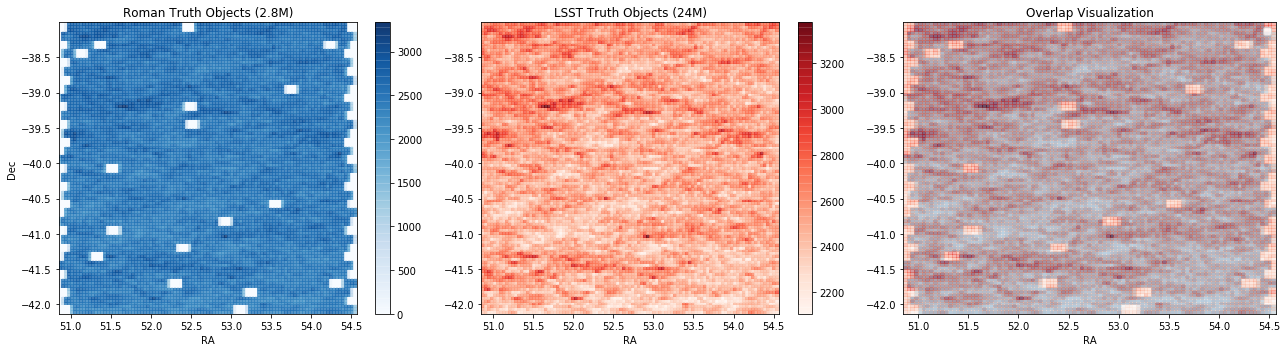

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ra_bins = np.linspace(min(master_df['ra'].min(), all_truth_cat['ra'].min()), 
                      max(master_df['ra'].max(), all_truth_cat['ra'].max()), 100)
dec_bins = np.linspace(min(master_df['dec'].min(), all_truth_cat['dec'].min()), 
                       max(master_df['dec'].max(), all_truth_cat['dec'].max()), 100)

# Roman data
im1 = axes[0].hist2d(master_df['ra'], master_df['dec'], bins=[ra_bins, dec_bins], 
                     cmap='Blues', alpha=0.8)
axes[0].set_title('Roman Truth Objects (2.8M)')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
plt.colorbar(im1[3], ax=axes[0])

# LSST data
im2 = axes[1].hist2d(all_truth_cat['ra'], all_truth_cat['dec'], bins=[ra_bins, dec_bins], 
                     cmap='Reds', alpha=0.8)
axes[1].set_title('LSST Truth Objects (24M)')
axes[1].set_xlabel('RA')
plt.colorbar(im2[3], ax=axes[1])

axes[2].hist2d(master_df['ra'], master_df['dec'], bins=[ra_bins, dec_bins], 
               cmap='Blues', alpha=0.6, label='Roman')
axes[2].hist2d(all_truth_cat['ra'], all_truth_cat['dec'], bins=[ra_bins, dec_bins], 
               cmap='Reds', alpha=0.4, label='LSST')
axes[2].set_title('Overlap Visualization')
axes[2].set_xlabel('RA')
plt.tight_layout()

## Querying Galaxies Morphology Info ONCE

In [11]:
cosmodf = all_truth_cat[(all_truth_cat['truth_type'] == 1)][['cosmodc2_id', 'cosmodc2_hp']]
print(len(np.unique(cosmodf['cosmodc2_id'])), f"galaxies out of {len(all_truth_cat['ra'])} objects")

24608471 galaxies out of 24748131 objects


In [12]:
healpix_pixels = np.unique(cosmodf['cosmodc2_hp'])
ids = cosmodf['cosmodc2_id']
healpix_pixels, len(ids)

(array([ 9810,  9811,  9938,  9939, 10066, 10067, 10194, 10195, 10321,
        10322]),
 24608471)

In [13]:
gal_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image', config_overwrite={'healpix_pixels': healpix_pixels})

In [14]:
bands = ['u','g','r','i','z','y']
bandnames = [f'mag_{band}' for band in bands]

disk_lums = [f'SDSS_filters/diskLuminositiesStellar:SDSS_{band}:observed' for band in bands if band != 'y']
spheroid_lums = [f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed' for band in bands if band != 'y']

magi_filter = [f'{bandnames[3]} < {29}']
coord_filters = [
    f'ra > {ra_min}',
    f'ra < {ra_max}',
    f'dec > {dec_min}',
    f'dec < {dec_max}'
]
redshift_filter = ['redshift > 0']
filters = redshift_filter + coord_filters + magi_filter
# filters = [magr_filter, magi_filter, redshift_filter]
cols_g = ["ra", "dec", "bulge_to_total_ratio_i", "convergence", "ellipticity_1_bulge_true", "ellipticity_1_disk_true",
        "ellipticity_1_true", "ellipticity_2_bulge_true", "ellipticity_2_disk_true", "ellipticity_2_true", 
        "galaxy_id", "mag_true_g", "mag_true_i", "mag_true_r", "mag_true_u", "mag_true_y", "mag_true_z",
        "position_angle_true", "position_angle_true_dc2", "redshift", "shear_1", "shear_2", "size_bulge_true", "size_disk_true",
        "size_minor_disk_true", "size_minor_bulge_true", "size_true", "size_minor_true", "R_v", "A_v", 
       "LSST_filters/spheroidLuminositiesStellar:LSST_y:observed", "LSST_filters/diskLuminositiesStellar:LSST_y:observed",
         "LSST_filters/spheroidLuminositiesStellar:LSST_u:observed", "LSST_filters/diskLuminositiesStellar:LSST_u:observed"] + bandnames + disk_lums + spheroid_lums

In [15]:
all_gal_cat = pd.DataFrame(gal_cat.get_quantities(cols_g, filters=filters))

In [17]:
print(f"Total objects in morphology catalog: {all_gal_cat.shape[0]}")

Total objects in morphology catalog: 27675498


In [18]:
all_gal_cat.to_parquet(f'{root_dir}all_lsst_overlap_tract_truth_morph.parquet') # 7.27 GB

In [ ]:
all_gal_cat = pd.read_parquet(f'{root_dir}all_lsst_overlap_tract_truth_morph.parquet')

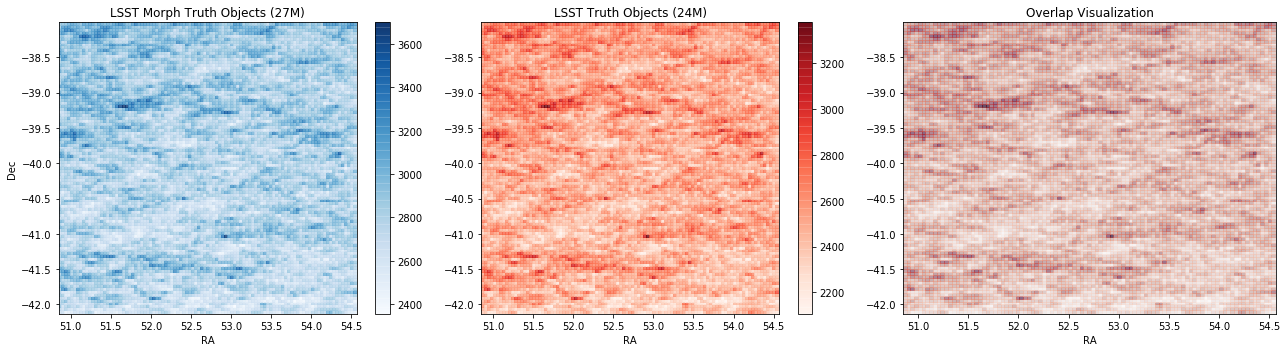

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ra_bins = np.linspace(min(all_gal_cat['ra'].min(), all_truth_cat['ra'].min()), 
                      max(all_gal_cat['ra'].max(), all_truth_cat['ra'].max()), 100)
dec_bins = np.linspace(min(all_gal_cat['dec'].min(), all_truth_cat['dec'].min()), 
                       max(all_gal_cat['dec'].max(), all_truth_cat['dec'].max()), 100)

# Roman data
im1 = axes[0].hist2d(all_gal_cat['ra'], all_gal_cat['dec'], bins=[ra_bins, dec_bins], 
                     cmap='Blues', alpha=0.8)
axes[0].set_title('LSST Morph Truth Objects (27M)')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
plt.colorbar(im1[3], ax=axes[0])

# LSST data
im2 = axes[1].hist2d(all_truth_cat['ra'], all_truth_cat['dec'], bins=[ra_bins, dec_bins], 
                     cmap='Reds', alpha=0.8)
axes[1].set_title('LSST Truth Objects (24M)')
axes[1].set_xlabel('RA')
plt.colorbar(im2[3], ax=axes[1])

axes[2].hist2d(all_gal_cat['ra'], all_gal_cat['dec'], bins=[ra_bins, dec_bins], 
               cmap='Blues', alpha=0.6, label='LSST Morph')
axes[2].hist2d(all_truth_cat['ra'], all_truth_cat['dec'], bins=[ra_bins, dec_bins], 
               cmap='Reds', alpha=0.4, label='LSST')
axes[2].set_title('Overlap Visualization')
axes[2].set_xlabel('RA')
plt.tight_layout()

In [20]:
filtered_gal_cat = all_gal_cat[all_gal_cat['galaxy_id'].isin(ids)].copy()
print(f"Filtered morphology data down to {len(filtered_gal_cat)} target galaxies.")
# filtered_gal_cat

Filtered morphology data down to 24608471 target galaxies.


In [26]:
filter_prefix = {
    'y': 'LSST_filters',
    'u': 'LSST_filters',
    'i': None,  # skipping 'i' band since we already have bulge_to_total_ratio_i
    'g': 'SDSS_filters',
    'r': 'SDSS_filters',
    'z': 'SDSS_filters',
}
for band in bands:
    prefix = filter_prefix[band]
    if prefix is None:
        continue
    spheroid_key = f'{prefix}/spheroidLuminositiesStellar:{prefix.split("_")[0]}_{band}:observed'
    disk_key     = f'{prefix}/diskLuminositiesStellar:{prefix.split("_")[0]}_{band}:observed'
    ratio_key    = f'bulge_to_total_ratio_{band}'

    filtered_gal_cat[ratio_key] = filtered_gal_cat[spheroid_key] / (
        filtered_gal_cat[spheroid_key] + filtered_gal_cat[disk_key]
    )

In [89]:
for band in bands:
    if band == 'y':
        filtered_gal_cat[f'bulge_to_total_ratio_y'] = filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed']/(filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed'] + filtered_gal_cat[f'LSST_filters/diskLuminositiesStellar:LSST_y:observed'])
    elif band == 'u':
        filtered_gal_cat[f'bulge_to_total_ratio_u'] = filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed']/(filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed'] + filtered_gal_cat[f'LSST_filters/diskLuminositiesStellar:LSST_u:observed'])
    else:
        if band != 'i':
            filtered_gal_cat[f'bulge_to_total_ratio_{band}'] = filtered_gal_cat[f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed']/(filtered_gal_cat[f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed'] + filtered_gal_cat[f'SDSS_filters/diskLuminositiesStellar:SDSS_{band}:observed'])

In [28]:
# Ensure no duplicate columns before merge except the key
cols_to_drop = [col for col in filtered_gal_cat.columns if col in all_truth_cat.columns and col != 'galaxy_id']
cols_to_drop

['mag_y', 'mag_g', 'mag_u', 'dec', 'mag_i', 'mag_z', 'mag_r', 'redshift', 'ra']

In [29]:
filtered_gal_cat_renamed = filtered_gal_cat.drop(columns=cols_to_drop).rename(columns={'galaxy_id': 'cosmodc2_id'})

In [30]:
filtered_gal_cat_renamed.columns

Index(['ellipticity_2_disk_true', 'position_angle_true',
       'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'shear_1',
       'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_disk_true', 'mag_true_y',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'mag_true_i', 'size_minor_true', 'R_v', 'size_minor_disk_true',
       'size_minor_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed', 'cosmodc2_id',
       'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
       'position_angle_true_dc2', 'size_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
       'LSST_filters/diskLuminositiesStellar:LSST_y:observed',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed',
       'SDSS_filters/diskLuminositiesStellar:SDSS_g:observed', 'mag_true_g',
       'shear_2', 'mag_true_r', 'size_true', 'mag_true_z',


In [31]:
print("Merging morphology data...")
truth_cat_morph = all_truth_cat.merge(
    filtered_gal_cat_renamed,
    on='cosmodc2_id',
    how='left',
    suffixes=('_truth_merged', '_cosmodc2')
)
print("Merge complete.")

Merging morphology data...
Merge complete.


In [32]:
truth_cat_morph.columns

Index(['id', 'mag_r', 'patch', 'flux_g', 'tract', 'mag_z', 'dec', 'mag_y',
       'rv', 'ra', 'cosmodc2_hp', 'av', 'mag_g', 'mag_u', 'flux_z',
       'host_galaxy', 'flux_i', 'truth_type', 'flux_r', 'cosmodc2_id',
       'flux_y', 'mag_i', 'id_string', 'flux_u', 'redshift',
       'ellipticity_2_disk_true', 'position_angle_true',
       'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'shear_1',
       'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_disk_true', 'mag_true_y',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'mag_true_i', 'size_minor_true', 'R_v', 'size_minor_disk_true',
       'size_minor_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed',
       'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
       'position_angle_true_dc2', 'size_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
      

In [36]:
truth_cat_morph

,id,mag_r,patch,flux_g,tract,mag_z,dec,mag_y,rv,ra,...,mag_true_u,SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed,ellipticity_2_true,size_disk_true,ellipticity_1_true,bulge_to_total_ratio_u,bulge_to_total_ratio_g,bulge_to_total_ratio_r,bulge_to_total_ratio_z,bulge_to_total_ratio_y
0,40969303200,25.427256,"1,5",81.956825,3075,23.877459,-41.872624,23.653072,3.1,52.326735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40969303522,23.634510,"1,5",416.703003,3075,22.561901,-41.874033,22.385714,3.1,52.305598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40249342213,18.238298,"1,5",61547.972656,3075,16.688648,-41.853156,16.464298,3.1,52.317830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40901163064,22.018303,"1,5",1625.568237,3075,19.416039,-41.861233,18.852198,3.1,52.336677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40245795634,20.732096,"1,5",5314.505371,3075,18.129753,-41.859700,17.565891,3.1,52.324060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,40969301912,26.613052,"1,5",27.499161,3075,25.063419,-41.851727,24.839075,3.1,52.334984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,40745448593,25.863552,"1,5",48.410263,3075,22.775461,-41.851573,21.940214,3.1,52.269024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,41020445889,25.104507,"1,5",110.878914,3075,23.351673,-41.862317,23.105953,3.1,52.290888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,41020445780,26.913250,"1,5",21.554893,3075,24.897354,-41.861359,24.625542,3.1,52.289896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,40901163106,24.246353,"1,5",244.431717,3075,22.493666,-41.864444,22.247978,3.1,52.322516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
truth_cat_filename = f'{root_dir}lsst_master_truth_df_700.parquet'
truth_cat_morph.to_parquet(truth_cat_filename)

# Creating LSST Master Detection Catalog

In [41]:
sorted(GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2').list_all_quantities())

['I_flag',
 'I_flag_g',
 'I_flag_i',
 'I_flag_r',
 'I_flag_u',
 'I_flag_y',
 'I_flag_z',
 'IxxPSF_pixel',
 'IxxPSF_pixel_g',
 'IxxPSF_pixel_i',
 'IxxPSF_pixel_r',
 'IxxPSF_pixel_u',
 'IxxPSF_pixel_y',
 'IxxPSF_pixel_z',
 'Ixx_pixel',
 'Ixx_pixel_g',
 'Ixx_pixel_i',
 'Ixx_pixel_r',
 'Ixx_pixel_u',
 'Ixx_pixel_y',
 'Ixx_pixel_z',
 'IxyPSF_pixel',
 'IxyPSF_pixel_g',
 'IxyPSF_pixel_i',
 'IxyPSF_pixel_r',
 'IxyPSF_pixel_u',
 'IxyPSF_pixel_y',
 'IxyPSF_pixel_z',
 'Ixy_pixel',
 'Ixy_pixel_g',
 'Ixy_pixel_i',
 'Ixy_pixel_r',
 'Ixy_pixel_u',
 'Ixy_pixel_y',
 'Ixy_pixel_z',
 'IyyPSF_pixel',
 'IyyPSF_pixel_g',
 'IyyPSF_pixel_i',
 'IyyPSF_pixel_r',
 'IyyPSF_pixel_u',
 'IyyPSF_pixel_y',
 'IyyPSF_pixel_z',
 'Iyy_pixel',
 'Iyy_pixel_g',
 'Iyy_pixel_i',
 'Iyy_pixel_r',
 'Iyy_pixel_u',
 'Iyy_pixel_y',
 'Iyy_pixel_z',
 'blendedness',
 'cModelFluxErr_g',
 'cModelFluxErr_i',
 'cModelFluxErr_r',
 'cModelFluxErr_u',
 'cModelFluxErr_y',
 'cModelFluxErr_z',
 'cModelFlux_flag_g',
 'cModelFlux_flag_i',
 'cModel

In [38]:
tracts = [
    3075, 3076, 
    3256, 3257, 3258, 
    3442, 3443, 3444, 
    3631, 3632, 3633
]

In [39]:
det_catalog = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2', config_overwrite={'tracts': tracts})

In [40]:
det_catalog.available_tracts

[3075, 3076, 3256, 3257, 3258, 3442, 3443, 3444, 3631, 3632, 3633]

In [45]:
from GCRCatalogs.helpers.tract_catalogs import tract_filter
# Based on https://www.lsst.org/scientists/keynumbers
# https://lsstdesc.org/DC2-analysis/tutorials/object_gcr_1_intro.html
bands = ['u','g','r','i','z','y']
# max_mag = 26.9
bandnames = [f'mag_{band}' for band in bands]
psf_fwhm_asec = [f'psf_fwhm_{band}' for band in bands]
# magr_filter = f'{bandnames[2]} < {max_mag}'
magi_filter = f'{bandnames[3]} < {29}' # i band mag cut
coord_filters = [
    f'ra > {ra_min}',
    f'ra < {ra_max}',
    f'dec > {dec_min}',
    f'dec < {dec_max}'
]
filters = [magi_filter] + coord_filters
# generates the correct query string for us since we can't pass in a list of tracts to native_filters=f'(tract == {tracts})'
native_filters_query = tract_filter(tracts)
# 'cosmodc2_hp_truth', 'cosmodc2_id_truth' 'flux_g_truth', 'flux_i_truth', 'flux_r_truth', 'flux_u_truth', 'flux_y_truth', 'flux_z_truth', 'truth_type'
# all above don't exist in dc2_obj without addons
cols_det = ['objectId', 'parentObjectId', 'x', 'y', 'ra', 'dec', 'extendedness', 'mag_u_cModel', 'mag_g_cModel', 'mag_r_cModel', 
    'snr_u_cModel', 'snr_g_cModel', 'snr_r_cModel', 'snr_i_cModel', 'snr_z_cModel', 'snr_y_cModel',
    'mag_i_cModel', 'mag_z_cModel', 'mag_y_cModel', 'good', 'clean', 'blendedness', 'tract', 'patch'] + bandnames + psf_fwhm_asec

In [46]:
all_det_cat = pd.DataFrame(det_catalog.get_quantities(cols_det, filters=filters, native_filters=native_filters_query))

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [48]:
print(f"Number of detected objects: {len(all_det_cat)}")
print(f"Number of unique detected objs: {len(all_det_cat['objectId'].value_counts())}")

Number of detected objects: 5663680
Number of unique detected objs: 5663680


In [49]:
all_det_cat['tract'].unique()

array([3075, 3076, 3256, 3257, 3258, 3442, 3443, 3444, 3631, 3632, 3633])

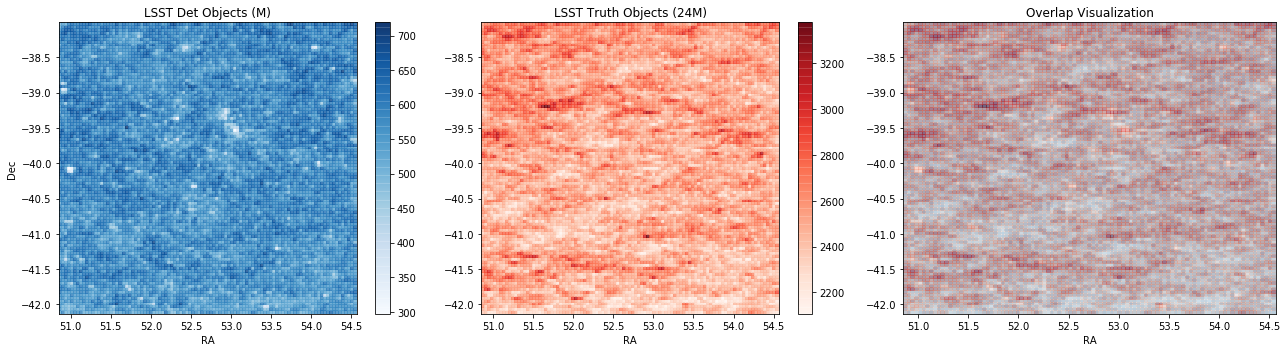

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ra_bins = np.linspace(min(all_det_cat['ra'].min(), all_truth_cat['ra'].min()), 
                      max(all_det_cat['ra'].max(), all_truth_cat['ra'].max()), 100)
dec_bins = np.linspace(min(all_det_cat['dec'].min(), all_truth_cat['dec'].min()), 
                       max(all_det_cat['dec'].max(), all_truth_cat['dec'].max()), 100)

# LSST Det objs
im1 = axes[0].hist2d(all_det_cat['ra'], all_det_cat['dec'], bins=[ra_bins, dec_bins], 
                     cmap='Blues', alpha=0.8)
axes[0].set_title('LSST Det Objects (5M)')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
plt.colorbar(im1[3], ax=axes[0])

# LSST Truth objs
im2 = axes[1].hist2d(all_truth_cat['ra'], all_truth_cat['dec'], bins=[ra_bins, dec_bins], 
                     cmap='Reds', alpha=0.8)
axes[1].set_title('LSST Truth Objects (24M)')
axes[1].set_xlabel('RA')
plt.colorbar(im2[3], ax=axes[1])

axes[2].hist2d(all_det_cat['ra'], all_det_cat['dec'], bins=[ra_bins, dec_bins], 
               cmap='Blues', alpha=0.6, label='LSST Det')
axes[2].hist2d(all_truth_cat['ra'], all_truth_cat['dec'], bins=[ra_bins, dec_bins], 
               cmap='Reds', alpha=0.4, label='LSST Truth')
axes[2].set_title('Overlap Visualization')
axes[2].set_xlabel('RA')
plt.tight_layout()

In [ ]:
det_cat_filename = f'{root_dir}lsst_master_det_df_700.parquet' # 1.28 GB
all_det_cat.to_parquet(det_cat_filename)

# Creating Per Tile Catalogs 

In [9]:
TILE_LIST_FILE = f'{root_dir}700_tiles.txt'
with open(TILE_LIST_FILE, 'r') as f:
    tiles = [line.strip() for line in f if line.strip()]

In [44]:
# roman_master_truth = pd.read_parquet(f'{root_dir}roman_master_truth_df_700.parquet')
lsst_master_truth = pd.read_parquet(f'{root_dir}lsst_master_truth_df_700.parquet') # has 24748131 unique entries each with their own id
lsst_master_det = pd.read_parquet(f'{root_dir}lsst_master_det_df_700.parquet') # has 5663680 unique entries each with their own objectID

In [12]:
print("roman_master_truth:", len(roman_master_truth))
print("lsst_master_truth:", len(lsst_master_truth))
print("lsst_master_det:", len(lsst_master_det))

roman_master_truth: 22826184
lsst_master_truth: 24748131
lsst_master_det: 5663680


In [1]:
0.2/0.05

4.0

## Tile Boundaries using Roman Master Truth Catalog

In [13]:
# let's group by tile and find the min/max RA/DEC
print("Calculating boundaries for each tile...")
# our pandas version is 0.24.2 so we don't have named aggregation syntax
tile_boundaries = roman_master_truth.groupby('tile')[['ra', 'dec']].agg({
    'ra': ['min', 'max'],
    'dec': ['min', 'max']
})
tile_boundaries.columns = ['ra_min', 'ra_max', 'dec_min', 'dec_max']
tile_boundaries = tile_boundaries.to_dict('index') 
# now we have a dict where {tile: {ra_min: ..., ra_max: ..., etc}}

# for newer pandas version (1.3+)
# tile_boundaries = roman_master_truth.groupby('tile').agg(
#     ra_min=('ra', 'min'),
#     ra_max=('ra', 'max'),
#     dec_min=('dec', 'min'),
#     dec_max=('dec', 'max')
# ).to_dict('index')
print(f"Successfully computed boundaries for {len(tile_boundaries)} tiles")
output_path = os.path.join(root_dir, "roman_700_tile_boundaries.json")
with open(output_path, "w") as f:
    json.dump(tile_boundaries, f, indent=2)
print(f"Tile boundaries saved to {output_path}")

Calculating boundaries for each tile...
Successfully computed boundaries for 700 tiles
Tile boundaries saved to /pscratch/sd/y/yaswante/MyQuota/roman_lsst/roman_700_tile_boundaries.json


Let's do a sanity check of these tile boundaries with a plot.

In [1]:
import os
import json

output_path = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/roman_700_tile_boundaries.json'

with open(output_path, "r") as f:
    tile_boundaries = json.load(f)

print(f"Loaded boundaries for {len(tile_boundaries)} tiles.")
sample_keys = list(tile_boundaries.keys())[:5]
for k in sample_keys:
    print(f"Tile: {k}, Boundaries: {tile_boundaries[k]}")

Loaded boundaries for 700 tiles.
Tile: 50.94_-39.9, Boundaries: {'ra_min': 50.8625558284, 'ra_max': 51.0254728309, 'dec_min': -40.0069238181, 'dec_max': -39.8820373377}
Tile: 50.94_-41.4, Boundaries: {'ra_min': 50.8534511246, 'ra_max': 51.0201018936, 'dec_min': -41.5067118464, 'dec_max': -41.3818189914}
Tile: 50.95_-39.0, Boundaries: {'ra_min': 50.8700632164, 'ra_max': 51.0309550332, 'dec_min': -39.1320511452, 'dec_max': -39.0071550628}
Tile: 50.95_-40.8, Boundaries: {'ra_min': 50.8668123658, 'ra_max': 51.0318865376, 'dec_min': -40.8818061192, 'dec_max': -40.7569352658}
Tile: 50.97_-38.1, Boundaries: {'ra_min': 50.8891246571, 'ra_max': 51.0480888968, 'dec_min': -38.2571649487, 'dec_max': -38.1323107203}


In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
def plot_tile_boundaries(tile_boundaries):
    fig, ax = plt.subplots(figsize=(18, 15))

    patches = []
    tile_centers = []
    for tile_id, bounds in tile_boundaries.items():
        ra_min, ra_max = bounds['ra_min'], bounds['ra_max']
        dec_min, dec_max = bounds['dec_min'], bounds['dec_max']
        corners = [
            (ra_min, dec_min),
            (ra_min, dec_max),
            (ra_max, dec_max),
            (ra_max, dec_min)
        ]
        patches.append(Polygon(corners, closed=True))
        tile_centers.append(((ra_min + ra_max) / 2, (dec_min + dec_max) / 2, tile_id))

    # Create and add PatchCollection once for all tiles
    collection = PatchCollection(
        patches,
        edgecolor='black',
        facecolor='lightblue',
        alpha=0.4
    )
    ax.add_collection(collection)

    for i, (center_ra, center_dec, tile_id) in enumerate(tile_centers):
        ax.text(center_ra, center_dec, f"{i}", ha='center', va='center', fontsize=13)

    ax.set_xlabel('RA (degrees)')
    ax.set_ylabel('Dec (degrees)')
    ax.set_title('Roman Tile Boundaries')
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True)

    all_ra = [b['ra_min'] for b in tile_boundaries.values()] + [b['ra_max'] for b in tile_boundaries.values()]
    all_dec = [b['dec_min'] for b in tile_boundaries.values()] + [b['dec_max'] for b in tile_boundaries.values()]
    ax.set_xlim(min(all_ra) - 0.1, max(all_ra) + 0.1)
    ax.set_ylim(min(all_dec) - 0.1, max(all_dec) + 0.1)
    plt.tight_layout()
    # plt.save

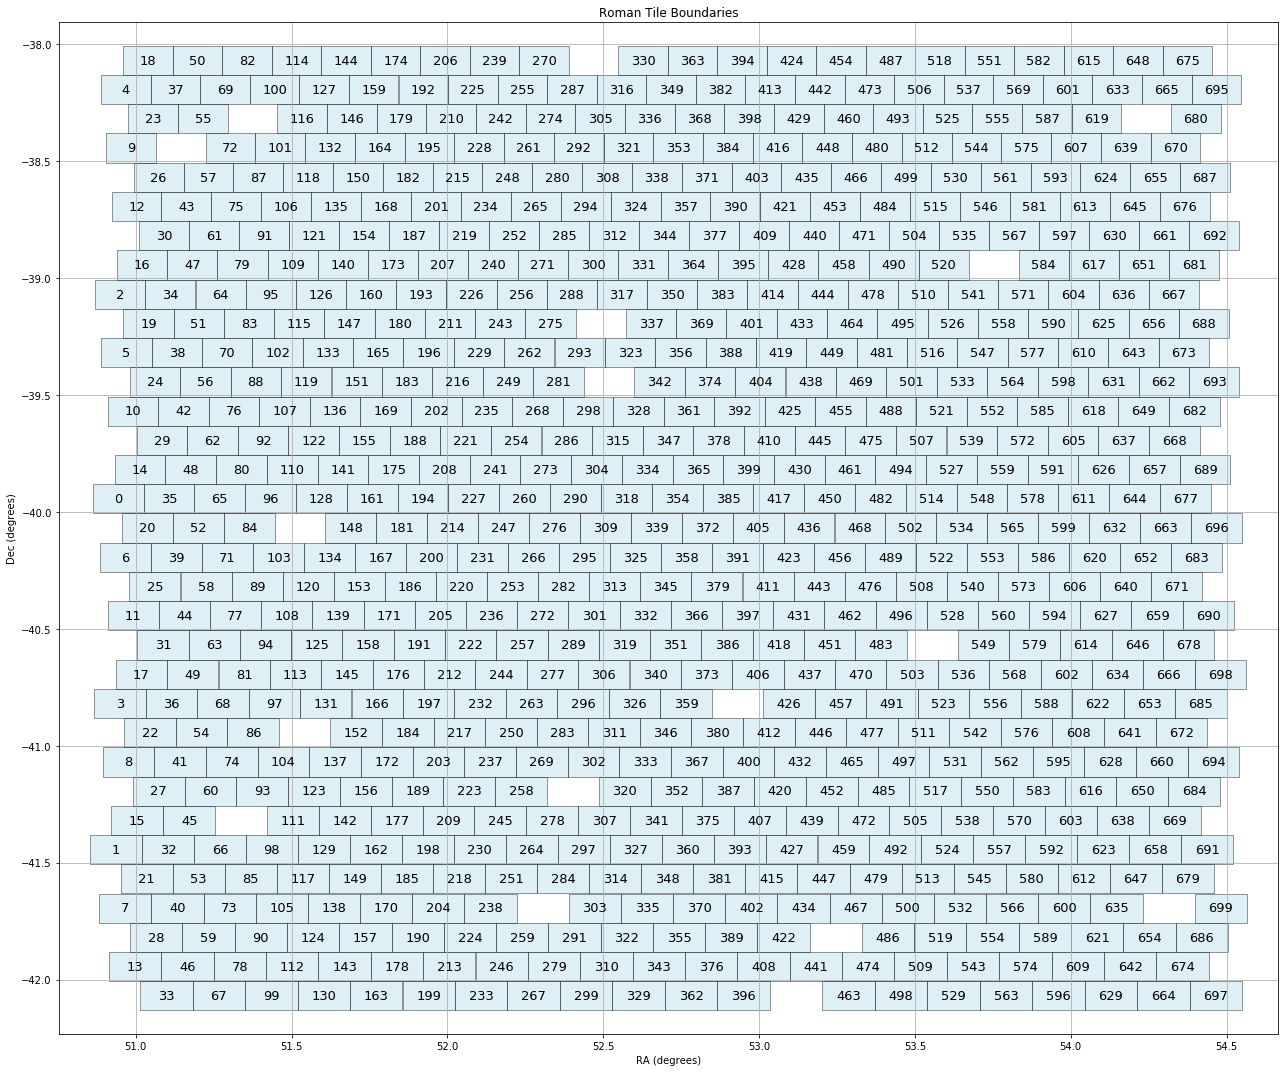

In [14]:
plot_tile_boundaries(tile_boundaries)

In [15]:
import numpy as np

# Overall boundaries from your LSST_Roman_MasterCatalogs.md notebook
ra_min_deg = 50.85345112
ra_max_deg = 54.56547722
dec_min_deg = -42.13163965
dec_max_deg = -38.00728567

# Convert degrees to radians for the trigonometric functions
ra_min_rad = np.deg2rad(ra_min_deg)
ra_max_rad = np.deg2rad(ra_max_deg)
dec_min_rad = np.deg2rad(dec_min_deg)
dec_max_rad = np.deg2rad(dec_max_deg)

# Calculate the area in steradians
delta_ra_rad = ra_max_rad - ra_min_rad
area_steradians = delta_ra_rad * (np.sin(dec_max_rad) - np.sin(dec_min_rad))

# Convert steradians to square degrees
# 1 steradian = (180/pi)^2 square degrees
area_sq_degrees = area_steradians * (180 / np.pi)**2

print(f"Area in steradians: {area_steradians:.4f}")
print(f"Total sky area: {area_sq_degrees:.2f} square degrees")

Area in steradians: 0.0036
Total sky area: 11.71 square degrees


Great! They look as expected. Let's move onto dividing the LSST master catalogs.

## Dividing Master LSST Catalogs per tile

In [23]:
output_dir = f'{root_dir}truth-lsst'
for tile in tqdm(tiles, desc="Processing Tiles"):
    bounds = tile_boundaries[tile]
    truth_mask = (
        (lsst_master_truth['ra'] >= bounds['ra_min']) & (lsst_master_truth['ra'] <= bounds['ra_max']) &
        (lsst_master_truth['dec'] >= bounds['dec_min']) & (lsst_master_truth['dec'] <= bounds['dec_max'])
    )
    tile_truth = lsst_master_truth[truth_mask]
    if tile_truth.empty:
        print(f"{tile}'s truth df is empty!")
    else:
        output_path = os.path.join(output_dir, tile, f'full_truth_{tile}.parquet')
        tile_truth.to_parquet(output_path, index=False)

    det_mask = (
        (lsst_master_det['ra'] >= bounds['ra_min']) & (lsst_master_det['ra'] <= bounds['ra_max']) &
        (lsst_master_det['dec'] >= bounds['dec_min']) & (lsst_master_det['dec'] <= bounds['dec_max'])
    )
    tile_det = lsst_master_det[det_mask]
    
    if tile_det.empty:
        print(f"{tile}'s det df is empty!")
    else:
        output_path = os.path.join(output_dir, tile, f'full_det_{tile}.parquet')
        tile_det.to_parquet(output_path, index=False)

Processing Tiles: 100%|██████████| 700/700 [02:43<00:00,  4.27it/s]


Let's do a sanity check of these per tile catalogs.

In [43]:
import glob
output_dir = f'{root_dir}truth-lsst'
print("Verifying LSST Truth Catalogs...")
truth_files = glob.glob(os.path.join(output_dir, '*', 'full_truth_*.parquet'))
recombined_truth_df = pd.concat([pd.read_parquet(f) for f in truth_files], ignore_index=True)
# checking for duplicates using `id` from truth catalog
num_duplicates_truth = recombined_truth_df.duplicated(subset=['id']).sum()
print(f"Found {num_duplicates_truth} duplicate objects at tile edges.")

Verifying LSST Truth Catalogs...
Found 0 duplicate objects at tile edges.


In [54]:
print(f"Original master LSST truth catalog has {len(lsst_master_truth)} objects.")
print(f"Recombined per-tile catalogs have {len(recombined_truth_df)} unique objects.")

Original master LSST truth catalog has 24748131 objects.
Recombined per-tile catalogs have 23073199 unique objects.


This discrepancy is accounted for since we have 16 tiles missing from our Roman data (since we've already processed these 16 tiles previously). If we did `len(lsst_master_truth[~combined_mask])` where `combined_mask` is the combo of all the tile boundary masks, we get the same amount of objects as `24748131 - 23073199 = 1674932` as expected.

In [55]:
import glob
output_dir = f'{root_dir}truth-lsst'
print("Verifying LSST Det Catalogs...")
det_files = glob.glob(os.path.join(output_dir, '*', 'full_det_*.parquet'))
recombined_det_df = pd.concat([pd.read_parquet(f) for f in det_files], ignore_index=True)
# checking for duplicates using `id` from truth catalog
num_duplicates_det = recombined_det_df.duplicated(subset=['objectId']).sum()
print(f"Found {num_duplicates_det} duplicate objects at tile edges.")
print(f"Original master LSST truth catalog has {len(lsst_master_det)} unique objects.")
print(f"Recombined per-tile catalogs have {len(recombined_det_df)} unique objects.") # 381387 in the 16 tiles

Verifying LSST Det Catalogs...
Found 0 duplicate objects at tile edges.
Original master LSST truth catalog has 5663680 unique objects.
Recombined per-tile catalogs have 5282293 unique objects.


Performing visual check for random tile: 52.74_-38.4


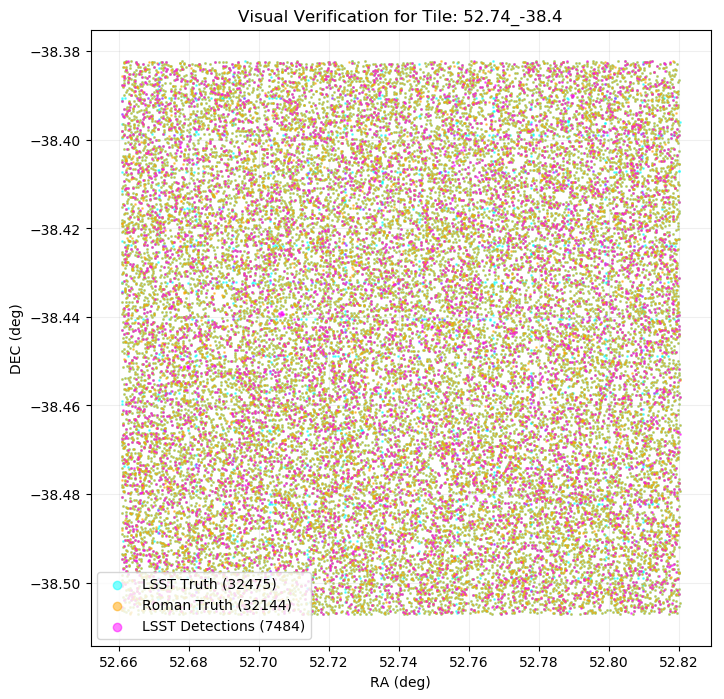

In [63]:
random_tile = random.choice(tiles)
print(f"Performing visual check for random tile: {random_tile}")
output_dir = f'{root_dir}truth-lsst'
per_tile_truth_path = os.path.join(output_dir, random_tile, f'full_truth_{random_tile}.parquet')
per_tile_det_path = os.path.join(output_dir, random_tile, f'full_det_{random_tile}.parquet')
per_tile_truth_df = pd.read_parquet(per_tile_truth_path)
per_tile_det_df = pd.read_parquet(per_tile_det_path)

roman_tile_df = roman_master_truth[roman_master_truth['tile'] == random_tile][['ra','dec']]

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(per_tile_truth_df['ra'], per_tile_truth_df['dec'], s=1, alpha=0.5,
           label=f'LSST Truth ({len(per_tile_truth_df)})', color='cyan')
ax.scatter(roman_tile_df['ra'], roman_tile_df['dec'], s=1, alpha=0.5,
           label=f'Roman Truth ({len(roman_tile_df)})', color='orange')
ax.scatter(per_tile_det_df['ra'], per_tile_det_df['dec'], s=1, alpha=0.5,
           label=f'LSST Detections ({len(per_tile_det_df)})', color='magenta')

ax.set_xlabel("RA (deg)")
ax.set_ylabel("DEC (deg)")
ax.set_title(f"Visual Verification for Tile: {random_tile}")
ax.legend(markerscale=6)
ax.grid(True, alpha=0.2)

Great! Now, we can move on to grabbing the cutouts and cutting these per-tile catalogs into per-cutout catalogs.